In [2]:
import argparse
import csv
import re
import os
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

import utils

from matplotlib.animation import FuncAnimation
from matplotlib.axes import Axes

def parse_trace(trace_file_name: str) -> pl.DataFrame:
    """
    # parse_trace

    Parse a trace file and return a polars DataFrame.

        Parameters:
            trace_file_name (str): The name of the trace file.

        Returns:
            polars.DataFrame: The parsed trace.

    Format of the trace file:
        (line number as index) gap ddl size prio

        Example:
            ```
            0.1 200 1300 1
            0.1 200 1300 2
    """
    trace = []
    with open(trace_file_name, "r") as f:
        lines = f.readlines()
        for idx, line in enumerate(lines):
            info = re.split(r"\s+", line)
            trace.append(
                {
                    "id": idx,
                    "start": float(info[0]),
                    "gap": float(info[0]),
                    "ddl": int(info[1]),
                    "size": int(info[2]),
                    "prio": int(info[3]),
                }
            )
    trace = pl.from_dicts(trace)
    trace["start"] = trace["start"].cumsum()
    return trace

def parse_server_log(server_log_file_name: str) -> pl.DataFrame:
    """
    # parse_server_log

    Parse a server log file and return a polars DataFrame.

        Parameters:
            server_log_file_name (str): The name of the server log file.

        Returns:
            polars.DataFrame: The parsed server log.

    Format of the server log file:
        CSV file with following columns:
        - block_id
        - start
        - complete
        - cancelled
        - cancelled_passed
    """
    try:
        server_log = pl.read_csv(server_log_file_name)
        server_log["block_id"] = server_log["block_id"].apply(lambda x: (x >> 2) - 1)
        return server_log
    except:
        return pl.DataFrame(
            None, ["block_id", "start", "complete", "cancelled", "cancelled_passed"]
        )

def parse_result(result_file_name: str) -> pl.DataFrame:
    """
    # parse_result

    Parse a result file and return a polars DataFrame.

        Parameters:
            result_file_name (str): The name of the result file.

        Returns:
            polars.DataFrame: The parsed result.

    Format of the result file:
        CSV file with following columns:
        - block_id
        - bct
        - size
        - priority
        - deadline
        - duration
    """
    try:
        result = pl.read_csv(result_file_name)
        result["block_id"] = result["block_id"].apply(lambda x: (x >> 2) - 1)
        return result
    except:
        return pl.DataFrame(
            None, ["block_id", "bct", "size", "priority", "deadline", "duration"]
        )
        
def find_unsend(result_file_name, trace_file_name):
    if trace_file_name is not None:
        block_num = utils.count_newlines(trace_file_name)
        trace = set(range(block_num))

        with open(result_file_name, "r") as f:
            reader = csv.DictReader(f)
            result = [((int(row["block_id"]) - 1) >> 2) - 1 for row in reader]

        res = sorted([(x, ((x + 1) << 2) + 1) for x in trace - set(result)])

        return (len(res), res)
    else:
        raise Exception("trace_file_name is None")


def total_time(trace_file_name):
    with open(trace_file_name, "r") as f:
        reader = csv.reader(f, delimiter=" ")
        return sum([float(row[0]) for row in reader])


def draw(result_file_name, trace_file_name):
    result = pl.read_csv(result_file_name)
    result["block_id"] = result["block_id"].apply(lambda x: (x >> 2) - 1)
    trace = parse_trace(trace_file_name).rename({"gap": "start"})
    trace["start"] = trace["start"].cumsum()
    result = result.join(trace, left_on="block_id", right_on="id", how="outer")
    print(result)
    result = result.select(
        [
            "block_id",
            (pl.col("bct") / 1000 < pl.col("ddl")).alias("intime"),
            # (
            #     (pl.col("duration") / 1000) < (pl.col("ddl") + pl.col("start") * 1000)
            # ).alias("intime"),
            "prio",
            "ddl",
            (pl.col("ddl") / 1e3 + pl.col("start")).alias("timestamp"),
        ]
    )
    print(result)

    x = result["timestamp"].to_numpy()
    y = np.zeros((8, len(x)))
    y_count = np.zeros(8)
    y_intime = np.zeros(8)
    for i in range(len(x)):
        y_count[result["prio"][i]] += 1
        if result["intime"][i]:
            y_intime[result["prio"][i]] += 1
        for j in range(8):
            y[j][i] = y_intime[j] / y_count[j] if y_count[j] > 0 else 1

    fig, ax = plt.subplots()
    # ax.plot(x, y[0], label="prio 0")
    ax.plot(x, y[1], label="prio 1")
    ax.plot(x, y[2], label="prio 2")
    # ax.plot(x, y[3], label="prio 3")
    # ax.plot(x, y[4], label="prio 4")
    # ax.plot(x, y[5], label="prio 5")
    # ax.plot(x, y[6], label="prio 6")
    # ax.plot(x, y[7], label="prio 7")

    ax.set_ylim(0, 1.05)
    ax.set_xlabel("time (s)")
    ax.set_ylabel("average intime ratio")
    ax.legend()

    plt.savefig(f"{os.path.basename(result_file_name).split('.')[0]}.png")

    result = result.groupby("prio").agg([pl.count(), (pl.col("intime") == True).sum()])
    print(result)

def hist(result_file_name, trace_file_name):
    trace = parse_trace(trace_file_name)
    # print(
    #     trace.groupby("prio").agg(
    #         [
    #             pl.count(),
    #             pl.mean("size").alias("size_mean"),
    #             pl.var("size").alias("size_var"),
    #         ]
    #     )
    # )
    # trace = trace.partition_by("prio")
    # prio_1 = trace[0]["size"].to_numpy()
    # prio_2 = trace[1]["size"].to_numpy()

    # fig, ax = plt.subplots()
    # ax.hist(prio_1, 100, density=True, label="prio 1")
    # ax.hist(prio_2, 100, density=True, label="prio 2")
    # ax.set_xlabel("size (bytes)")
    # ax.set_ylabel("density")
    # trace = trace["size"].to_numpy()
    # fig, ax = plt.subplots()
    # # ax.plot(trace)
    # ax.scatter(np.arange(len(trace)), trace)
    # plt.savefig("trace_size.png")

    # result = pl.read_csv(result_file_name)
    # print(
    #     result.groupby("priority").agg(
    #         [
    #             pl.count(),
    #             pl.mean("bct").alias("bct_mean"),
    #             pl.var("bct").alias("bct_var"),
    #         ]
    #     )
    # )
    # result = result.partition_by("priority")
    # prio_1 = result[0]["bct"].to_numpy()
    # prio_2 = result[1]["bct"].to_numpy()
    # fig, ax = plt.subplots()
    # ax.hist(prio_1, 100, density=True, label="prio 1")
    # ax.hist(prio_2, 100, density=True, label="prio 2")
    # ax.set_xlabel("bct (us)")
    # ax.set_ylabel("density")
    # plt.savefig("result_bct_hist.png")

In [3]:
for style in plt.style.available:
    print(style)

Solarize_Light2
_classic_test_patch
_mpl-gallery
_mpl-gallery-nogrid
bmh
classic
dark_background
fast
fivethirtyeight
ggplot
grayscale
seaborn
seaborn-bright
seaborn-colorblind
seaborn-dark
seaborn-dark-palette
seaborn-darkgrid
seaborn-deep
seaborn-muted
seaborn-notebook
seaborn-paper
seaborn-pastel
seaborn-poster
seaborn-talk
seaborn-ticks
seaborn-white
seaborn-whitegrid
tableau-colorblind10


# trace hist

In [4]:
from xml.dom.pulldom import PROCESSING_INSTRUCTION


plt.style.use("seaborn-white")
def trace_hist(trace_file_name):
    trace = parse_trace(trace_file_name)
    # print the distribution of block_size, ddl and priority with block num
    # print(
    #     trace.groupby("prio").agg(
    #         [
    #             pl.count(),
    #             pl.mean("size").alias("size_mean"),
    #             pl.var("size").alias("size_var"),
    #         ]
    #     )
    # )
    prio_trace = trace.partition_by("prio")
    prio_1 = prio_trace[0]["size"].to_numpy()
    prio_2 = prio_trace[1]["size"].to_numpy()

    # fig, ax = plt.subplots()
    # ax.hist(prio_1, 100, label="prio 1")
    # ax.hist(prio_2, 100, density=True, label="prio 2")
    # ax.set_xlabel("size (bytes)")
    # ax.set_ylabel("density")

    # fig, ax = plt.subplots()
    # ax.hist(prio_1, 100, density=True, label="prio 1")
    # ax.hist(prio_2, 100, density=True, label="prio 2")
    # ax.set_xlabel("size (bytes)")
    # ax.set_ylabel("density")

    # block size trend with block num
    size_trace = trace["size"].to_numpy()
    fig, ax = plt.subplots()
    ax.bar([1], [len(prio_trace[0]["prio"])], color=["orange"], width=0.5, label="high priority")
    ax.bar([2], [len(prio_trace[1]["prio"])], color=["blue"], width=0.5, label="low priority")
    ax.set_xlabel("priority")
    ax.set_ylabel("block number")
    ax.legend(ncol=2, bbox_to_anchor=(0.5, 1),
              loc='lower center')

    # distribution of trace
    fig, ax = plt.subplots()
    size = 28
    # ax.scatter(np.arange(len(trace[:size])), size_trace[:size], c=["orange" if trace[i]["prio"][0] == 1 else "blue" for i in range(len(size_trace[:size]))])
    xarray = []
    for i in range(size):
        if trace[i]["prio"][0] == 1:
            xarray.append(i)
    ax.bar(xarray, size_trace[:len(xarray)], color="orange", label="high prioriy") 
    xarray = []
    for i in range(size):
        if trace[i]["prio"][0] == 2:
            xarray.append(i)
    ax.bar(xarray, size_trace[:len(xarray)], color="blue", label="low priority")
    ax.set_xlabel("block No.")
    ax.set_ylabel("size (bytes)")
    ax.set_xlim((0, 25))
    ax.legend(ncol=2, bbox_to_anchor=(0.5, 1),
              loc='lower center')
    # ax.plot(size_trace)
    # ax.scatter(prio_trace[0]["id"].to_numpy(), prio_trace[0]["size"].to_numpy(), c=["red"])
    # ax.scatter(prio_trace[1]["id"].to_numpy(), prio_trace[1]["size"].to_numpy(), c=["yellow"])
    # plt.savefig("trace_size.png")

    # result = pl.read_csv(result_file_name)
    # print(
    #     result.groupby("priority").agg(
    #         [
    #             pl.count(),
    #             pl.mean("bct").alias("bct_mean"),
    #             pl.var("bct").alias("bct_var"),
    #         ]
    #     )
    # )
    # result = result.partition_by("priority")
    # prio_1 = result[0]["bct"].to_numpy()
    # prio_2 = result[1]["bct"].to_numpy()
    # fig, ax = plt.subplots()
    # ax.hist(prio_1, 100, density=True, label="prio 1")
    # ax.hist(prio_2, 100, density=True, label="prio 2")
    # ax.set_xlabel("bct (us)")
    # ax.set_ylabel("density")
    # plt.savefig("result_bct_hist.png")
#trace_hist("data/trace_1300_1ms_1000_seq012.txt")

# get stats

In [47]:
def get_trace_prio(trace, max_prio=3):
    prio_list = trace.partition_by("prio")
    # sort
    prio_list.sort(key=lambda x: x["prio"][0])
    return prio_list
# good put and avg bct
def get_stats(result_file_path, trace_file_path=""):
    print("stats of %s" % result_file_path)
    trace = parse_trace(trace_file_path)
    trace_prios = get_trace_prio(trace)
    trace_size = len(trace)

    all_bytes = np.sum(trace["size"].to_numpy())
    all_time = trace["start"][-1] + trace["ddl"][-1] * 1e-3
    ideal_throughput = all_bytes / all_time
    result = parse_result(result_file_path)
    in_time = result.filter(pl.col("bct") <= pl.col("deadline"))
    good_bytes = np.sum(in_time["size"].to_numpy())
    total_bytes = np.sum(result["size"].to_numpy())
    finish_time = result["duration"][-1] # micro
    throughput = total_bytes * 8 / finish_time # Mbps
    goodput = good_bytes * 8 / finish_time # Mbps
    avg_bct = np.average(result["bct"].to_numpy()) #ms

    prio_result = result.partition_by("priority")
    prio_result.sort(key=lambda x: x["priority"][0])
    for idx, prio_frame in enumerate(prio_result):
        print(idx)
        avg_prio_bct = np.average(prio_frame["bct"].to_numpy()) #ms
        print("prio ", prio_frame["priority"][0], avg_prio_bct)
        print("prio", prio_frame["priority"][0], len(prio_frame.filter(pl.col("bct") <= pl.col("deadline"))) / len(trace_prios[idx]))

    # print("ideal throughput: ", ideal_throughput)
    print("throughput:", throughput)
    print("goodput: ", goodput)
    print("avg_bct: ", avg_bct)
get_stats("data/client_n_n_fifo.csv", "data/trace_1300_1ms_1000_seq012.txt")

stats of data/client_n_n_fifo.csv
0
prio  1 6272.96
prio 1 0.161
1
prio  2 6253.49
prio 2 0.072
throughput: 79.15136283311222
goodput:  24.141165664099226
avg_bct:  6263.225


# get table stats

In [6]:
# good put and avg bct
def get_table_stats(result_file_paths, trace_file_path= "", labels=[]):
    print("stats of %s" % str(result_file_paths))
    while len(labels) < len(result_file_paths):
        labels.append("#" + str(len(labels)))
    result_throughput = []
    result_goodput = []
    result_avg_bct = []
    result_prio1_bct = []
    result_prio2_bct = []
    for result_file_path in result_file_paths:
        result = parse_result(result_file_path)
        in_time = result.filter(pl.col("bct") <= pl.col("deadline"))
        good_bytes = np.sum(in_time["size"].to_numpy())
        total_bytes = np.sum(result["size"].to_numpy())
        finish_time = result["duration"][-1] # micro
        throughput = total_bytes * 8 / finish_time # Mbps
        goodput = good_bytes * 8 / finish_time # Mbps
        avg_bct = np.average(result["bct"].to_numpy()) #ms

        result_throughput.append(throughput)
        result_goodput.append(goodput)
        result_avg_bct.append(avg_bct)

        prio_result = result.partition_by("priority")
        for idx, prio_frame in enumerate(prio_result):
            avg_prio_bct = np.average(prio_frame["bct"].to_numpy()) #ms
            if prio_frame["priority"][0] == 1:
                result_prio1_bct.append(avg_prio_bct)
            elif prio_frame["priority"][0] == 2:
                result_prio2_bct.append(avg_prio_bct)
            else:
                print("priority %d is not expected" % (prio_frame["priority"][0]))
    print("|\t| %s |" % (" | ".join(labels)))
    print("| Throughput (Mbps) | %s |" % (" | ".join([x for x in map(lambda x: "%0.2f" % (x), result_throughput)])))
    print("| Goodput (Mbps) | %s |" % (" | ".join([x for x in map(lambda x: "%0.2f" % (x), result_goodput)])))
    print("| 平均块完成时间 (ms) | %s |" % (" | ".join([x for x in map(lambda x: "%d" % (int(x)), result_avg_bct)])))
    print("| 高优先级块平均完成时间 (ms) | %s |" % (" | ".join([x for x in map(lambda x: "%d" % (int(x)), result_prio1_bct)])))
    print("| 低优先级块平均完成时间 (ms) | %s |" % (" | ".join([x for x in map(lambda x: "%d" % (int(x)), result_prio2_bct)])))
get_table_stats(["data/client_n_n_fifo.csv", "data/client_n_n.csv"], labels=["QUIC", "DTP"])

stats of ['data/client_n_n_fifo.csv', 'data/client_n_n.csv']
|	| QUIC | DTP |
| Throughput (Mbps) | 79.15 | 37.23 |
| Goodput (Mbps) | 24.14 | 37.08 |
| 平均块完成时间 (ms) | 6263 | 3040 |
| 高优先级块平均完成时间 (ms) | 6272 | 2495 |
| 低优先级块平均完成时间 (ms) | 6253 | 4487 |


# draw figs

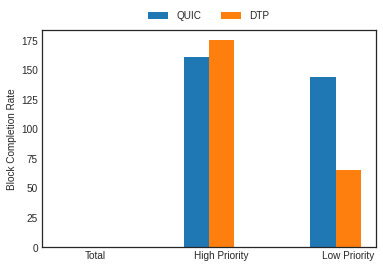

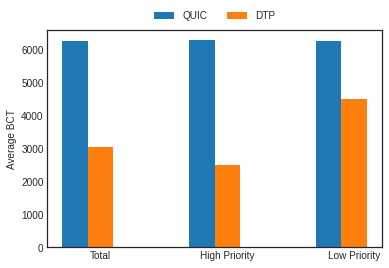

In [37]:
def draw_in_time_rate(result_file_path1, result_file_path2, trace_file_path, label1="QUIC", label2="DTP"):
    trace = parse_trace(trace_file_path)
    trace_prio1, trace_prio2 = trace.partition_by("prio")
    trace_size = len(trace)
    result1_bcr = []
    result2_bcr = []
    for result_file_path in [result_file_path1, result_file_path2]:
        result = parse_result(result_file_path)
        result_prio2, result_prio1 = result.partition_by("priority")
        if result_file_path1 == result_file_path:
            result_bcr = result1_bcr
        else:
            result_bcr = result2_bcr
        # total_bcr = len(result.filter(pl.col("bct") <= pl.col("deadline"))) / trace_size
        prio1_bcr = len(result_prio1.filter(pl.col("bct") <= pl.col("deadline"))) / len(trace_prio1)
        prio2_bcr = len(result_prio2.filter(pl.col("bct") <= pl.col("deadline"))) / len(trace_prio2)
        # result_bcr.append(total_bcr)
        result_bcr.append(prio1_bcr)
        result_bcr.append(prio2_bcr)

    labels = ["High Priority", "Low Priority"]
    # quic_bcr = [len(results[0].filter(pl.col("bct") <= pl.col("deadline"))) / trace_size, 0, 0]
    # dtp_bcr = [len(results[1].filter(pl.col("bct") <= pl.col("deadline"))) / trace_size, 0, 0]
    x = np.arange(len(labels))  # the label locations
    width = 0.30  # the width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, result1_bcr, width, label=label1)
    rects2 = ax.bar(x + width/2, result2_bcr, width, label=label2)
    ax.set_ylabel('Block Completion Rate')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

def draw_avg_bct(result_file_path1, result_file_path2, trace_file_path, label1="QUIC", label2="DTP"):
    trace = parse_trace(trace_file_path)
    trace_prio1, trace_prio2 = trace.partition_by("prio")
    trace_size = len(trace)
    result1_bct = []
    result2_bct = []
    for result_file_path in [result_file_path1, result_file_path2]:
        result = parse_result(result_file_path)
        result_prio2, result_prio1 = result.partition_by("priority")
        if result_file_path1 == result_file_path:
            result_bcr = result1_bct
        else:
            result_bcr = result2_bct
        # total_bct = np.average(result["bct"].to_numpy())
        prio1_bct = np.average(result_prio1["bct"].to_numpy())
        prio2_bct = np.average(result_prio2["bct"].to_numpy())
        # result_bcr.append(total_bct)
        result_bcr.append(prio1_bct)
        result_bcr.append(prio2_bct)

    labels = ["High Priority", "Low Priority"]
    # quic_bcr = [len(results[0].filter(pl.col("bct") <= pl.col("deadline"))) / trace_size, 0, 0]
    # dtp_bcr = [len(results[1].filter(pl.col("bct") <= pl.col("deadline"))) / trace_size, 0, 0]
    x = np.arange(len(labels))  # the label locations
    width = 0.30  # the width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, result1_bct, width, label=label1)
    rects2 = ax.bar(x + width/2, result2_bct, width, label=label2)
    ax.set_ylabel('Average BCT')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

def draw_cmp_fig(result_file_paths=[], trace_file_path="", labels=[], width=0.2, with_total=True):
    if not trace_file_path:
        print("no trace file path")
        return
    while len(labels) < len(result_file_paths):
        labels.append("#" + str(len(labels)))
    trace = parse_trace(trace_file_path)
    trace_prios = get_trace_prio(trace)
    trace_size = len(trace)
    bcrs = [[] for r in result_file_paths]
    bcts = [[] for r in result_file_paths]

    for idx, result_file_path in enumerate(result_file_paths):
        result = parse_result(result_file_path)
        result_prios = result.partition_by("priority")
        result_prios.sort(key=lambda x: x["priority"][0])
        
        result_bcr = bcrs[idx]
        total_bcr = len(result.filter(pl.col("bct") <= pl.col("deadline"))) / trace_size
        if with_total:
            result_bcr.append(total_bcr)

        for i, result_prio in enumerate(result_prios):
            prio_bcr = len(result_prio.filter(pl.col("bct") <= pl.col("deadline")) / len(trace_prios[i]))
            result_bcr.append(prio_bcr)

        result_bct = bcts[idx]
        total_bct = np.average(result["bct"].to_numpy())
        if with_total:
            result_bct.append(total_bct)

        for i, result_prio in enumerate(result_prios):
            prio_bct = np.average(result_prio["bct"].to_numpy())
            result_bct.append(prio_bct)
    
    # if with_total:
    #     x_labels = ["Total", "High Priority", "Low Priority"]
    # else:
    #     x_labels = ["High Priority", "Low Priority"]
    if with_total:
        x_labels = ["Total"]
    else:
        x_labels = []

    for i in range(len(trace_prios)):
        x_labels.append("prio %d" % i)

    x = np.arange(len(x_labels))  # the label locations
    fig, ax = plt.subplots()
    for idx, bcr in enumerate(bcrs):
        ax.bar(x + width * (idx - len(bcrs) // 2), bcr, width, label=labels[idx])
    ax.set_ylabel('Block Completion Rate')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    ax.legend(ncol=len(x_labels) + 1, bbox_to_anchor=(0.5, 1),
              loc='lower center')

    x = np.arange(len(x_labels))  # the label locations
    fig, ax = plt.subplots()
    for idx, bct in enumerate(bcts):
        ax.bar(x + width * (idx - len(bcts) // 2), bct, width, label=labels[idx])
    ax.set_ylabel('Average BCT')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    # ax.legend()
    ax.legend(ncol=len(x_labels) + 1, bbox_to_anchor=(0.5, 1),
              loc='lower center')
draw_cmp_fig(["data/client_n_n_fifo.csv", "data/client_n_n.csv"], "data/trace_1300_1ms_1000_seq012.txt", ["QUIC", "DTP"])

# original data1

## trace hist

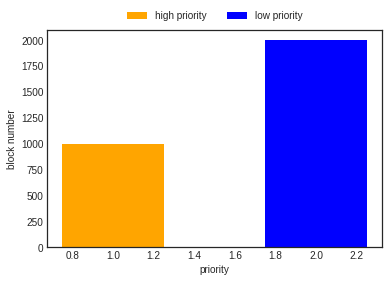

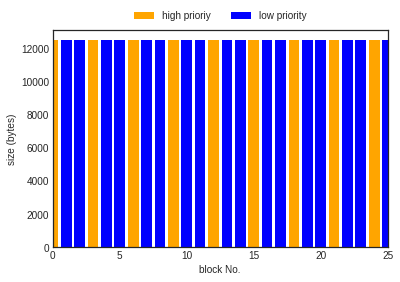

In [7]:
trace_hist("data/trace_1300_1ms_1000_seq012.txt")

## fifo on/off

In [8]:
get_stats("data/client_n_n_fifo.csv")
get_stats("data/client_n_n.csv")
draw_cmp_fig(["data/client_n_n_fifo.csv", "data/client_n_n.csv"], "data/trace_1300_1ms_1000_seq012.txt", ["QUIC", "DTP"])

stats of data/client_n_n_fifo.csv


FileNotFoundError: [Errno 2] No such file or directory: ''

## tos on/off

In [ ]:
get_stats("data/client_t_n_fifo.csv")
get_stats("data/client_t_t_fifo.csv")
draw_cmp_fig(["data/client_t_n_fifo.csv", "data/client_t_t_fifo.csv"], "data/trace_1300_1ms_1000_seq012.txt", ["QUIC", "DTP"])

: 

# data display

## original data all

In [ ]:
get_stats("data/client_n_n_fifo.csv")
get_stats("data/client_n_n.csv")
get_stats("data/client_t_t_fifo.csv")
get_stats("data/client_t_t.csv")

: 

In [ ]:
draw_cmp_fig(["data/client_n_n_fifo.csv", "data/client_n_n.csv", "data/client_t_t_fifo.csv", "data/client_t_t.csv"], "data/trace_1300_1ms_1000_seq012.txt")

: 

## 25 data 100000 1

In [ ]:
n_n_file = "25data/client_25_100000_1_n_n.csv"
n_t_file = "25data/client_25_100000_1_n_t.csv" 
t_n_file = "25data/client_25_100000_1_t_n.csv" 
t_t_file = "25data/client_25_100000_1_t_t.csv" 
get_stats(n_n_file)
get_stats(n_t_file)
get_stats(t_n_file)
get_stats(t_t_file)
draw_cmp_fig([n_n_file, n_t_file, t_n_file, t_t_file], "trace_tos_2.txt")

: 

## 25 data 10000 1

In [ ]:
n_n_file = "25data/client_25_10000_1_n_n.csv"
n_t_file = "25data/client_25_10000_1_n_t.csv" 
t_n_file = "25data/client_25_10000_1_t_n.csv" 
t_t_file = "25data/client_25_10000_1_t_t.csv" 
get_stats(n_n_file)
get_stats(n_t_file)
get_stats(t_n_file)
get_stats(t_t_file)
draw_cmp_fig([n_n_file, n_t_file, t_n_file, t_t_file], "trace_tos_1.txt")

: 

## 25 data 30000 1

In [ ]:
n_n_file = "25data/client_25_30000_1_n_n.csv"
n_t_file = "25data/client_25_30000_1_n_t.csv" 
t_n_file = "25data/client_25_30000_1_t_n.csv" 
t_t_file = "25data/client_25_30000_1_t_t.csv" 
get_stats(n_n_file)
get_stats(n_t_file)
get_stats(t_n_file)
get_stats(t_t_file)
draw_cmp_fig([n_n_file, n_t_file, t_n_file, t_t_file], "trace_tos_3.txt")

: 

#  Paper result 30000

In [16]:
n_n_file = "25data/client_25_30000_1_n_n.csv"
n_t_file = "25data/client_25_30000_1_n_t.csv" 
t_n_file = "25data/client_25_30000_1_t_n.csv" 
t_t_file = "25data/client_25_30000_1_t_t.csv" 
trace_file = "trace_tos_3.txt"

## trace hist

In [17]:
trace_hist(trace_file)

FileNotFoundError: [Errno 2] No such file or directory: 'trace_tos_3.txt'

## fifo on/off

In [15]:
get_table_stats([n_n_file, t_n_file], labels=["QUIC", "DTP"])
draw_cmp_fig([n_n_file, t_n_file], trace_file, ["QUIC", "DTP"], width=0.4)

NameError: name 'n_n_file' is not defined

## tos on/off

In [ ]:
get_table_stats([n_n_file, n_t_file], labels=["NO DS", "DS"])
draw_cmp_fig([n_n_file, n_t_file], trace_file, ["NO DS", "DS"], width=0.4)

: 

## final stats

In [ ]:
get_stats(n_n_file, trace_file)
print()
get_stats(n_t_file, trace_file)
print()
get_stats(t_n_file, trace_file)
print()
get_stats(t_t_file, trace_file)
draw_cmp_fig([n_n_file, n_t_file, t_n_file, t_t_file], trace_file, labels=["QUIC", "DTP", "QUIC + DS", "DTP + DS"], width=0.2)

: 

# Playground

In [51]:
n_n_file = "../dtp-test/examples/dtp_test/client_legacy_loss0_basic.csv"
n_t_file = "../dtp-test/examples/dtp_test/client_legacy_loss0_basic_tos.csv"
t_n_file = "../dtp-test/examples/dtp_test/client_legacy_loss0.csv"
t_t_file = "../dtp-test/examples/dtp_test/client_legacy_loss0_tos.csv"
trace_file = "../dtp-test/examples/dtp_test/trace/block_trace/aitrans_block.txt"
get_stats(n_n_file, trace_file)
print()
get_stats(n_t_file, trace_file)
print()
get_stats(t_n_file, trace_file)
print()
get_stats(t_t_file, trace_file)

stats of ../dtp-test/examples/dtp_test/client_legacy_loss0_basic.csv
0
prio  1 8516.78205128205
prio 1 0.40825035561877665
1
prio  2 85842.35555555555
prio 2 0.03611111111111111
throughput: 1.0698181144992136
goodput:  0.01609063827411375
avg_bct:  34728.84086629002

stats of ../dtp-test/examples/dtp_test/client_legacy_loss0_basic_tos.csv
0
prio  1 7664.011396011396
prio 1 0.39971550497866287
1
prio  2 85735.44722222222
prio 2 0.025
throughput: 1.0853978384607073
goodput:  0.014610584416245607
avg_bct:  34128.904896421845

stats of ../dtp-test/examples/dtp_test/client_legacy_loss0.csv
0
prio  1 61.173789173789174
prio 1 0.9985775248933144
1
prio  2 162.140625
prio 2 0.1111111111111111
throughput: 0.6423501915322876
goodput:  0.5413443100644737
avg_bct:  69.60966057441253

stats of ../dtp-test/examples/dtp_test/client_legacy_loss0_tos.csv
0
prio  1 64.01997146932953
prio 1 0.9971550497866287
1
prio  2 151.75384615384615
prio 2 0.13055555555555556
throughput: 0.6291369405578351
goodput: 

In [104]:
n_n_file = "../dtp-test/examples/dtp_test/client_video_n_n.csv"
n_t_file = "../dtp-test/examples/dtp_test/client_video_n_t.csv"
t_n_file = "../dtp-test/examples/dtp_test/client_video_t_n.csv"
t_t_file = "~/dtp-test/examples/dtp_test/client_video_t_t.csv"
trace_file = "./video_control.txt"
get_stats(n_n_file, trace_file)
print()
get_stats(n_t_file, trace_file)
print()
get_stats(t_n_file, trace_file)
print()
get_stats(t_t_file, trace_file)
# draw_cmp_fig(["~/dtp-test/examples/dtp_test/client_ddl_100_basic.csv", "~/dtp-test/examples/dtp_test/client_ddl_100.csv"], "./video_control.txt", ["QUIC", "DTP"], width=0.4)

stats of ../dtp-test/examples/dtp_test/client_video_n_n.csv
0
prio  0 12220.66265060241
prio 0 0.009036144578313253
1
prio  1 29210.275
prio 1 0.008333333333333333
2
prio  2 4608.776617954071
prio 2 0.25
throughput: 1.2669331416256053
goodput:  0.06487320763380235
avg_bct:  10494.196562835661

stats of ../dtp-test/examples/dtp_test/client_video_n_t.csv
0
prio  0 12506.210843373494
prio 0 0.006024096385542169
1
prio  1 28603.575
prio 1 0.008333333333333333
2
prio  2 4290.789583333333
prio 2 0.275
throughput: 1.2766111403289142
goodput:  0.06636824290745649
avg_bct:  10347.714592274679

stats of ../dtp-test/examples/dtp_test/client_video_t_n.csv
0
prio  0 71.55755395683454
prio 0 0.7590361445783133
1
prio  1 121.3076923076923
prio 1 0.26666666666666666
2
prio  2 92.56589147286822
prio 2 0.7541666666666667
throughput: 1.595878177884876
goodput:  1.4262978385105283
avg_bct:  85.8622159090909

stats of ~/dtp-test/examples/dtp_test/client_video_t_t.csv
0
prio  0 72.62989323843416
prio 0 0.76